In [129]:
import os
import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [130]:
DATA_SET = "dataset.csv"

In [254]:
def load_dataset(date, filename=DATA_SET):
    """
    Load training data from the one of the data/date folders.

    :parameter date (string): The date folder name.  Ex: "2020-02-05"
    :parameter filename (string): The csv filename.
    :returns a pandas dataframe.
    """

    basepath = os.path.abspath('')
    filepath = os.path.abspath(os.path.join(basepath, "..", "..")) + "/data/" + date + "/" + filename
    return pd.read_csv(filepath)

## Load Dataset

In [199]:
data = load_dataset("2020-04-05")
data.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,05/04/2020,5,4,2020,35,1,Afghanistan,AF,AFG,37172386.0
1,04/04/2020,4,4,2020,0,0,Afghanistan,AF,AFG,37172386.0
2,03/04/2020,3,4,2020,43,0,Afghanistan,AF,AFG,37172386.0
3,02/04/2020,2,4,2020,26,0,Afghanistan,AF,AFG,37172386.0
4,01/04/2020,1,4,2020,25,0,Afghanistan,AF,AFG,37172386.0


## Data Preparation

In [200]:
# Drop unnecessary fields
data.drop(['day', 'month', 'year'], axis=1, inplace=True)

In [201]:
# Format the data as a datetime object
data['dateRep'] = data['dateRep'].apply(lambda x: dt.datetime.strptime(x, '%d/%m/%Y'))

In [202]:
# Rename date column
data = data.rename(columns={'dateRep': 'date'})

## Get Familiar with the Data

In [203]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8905 entries, 0 to 8904
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     8905 non-null   datetime64[ns]
 1   cases                    8905 non-null   int64         
 2   deaths                   8905 non-null   int64         
 3   countriesAndTerritories  8905 non-null   object        
 4   geoId                    8883 non-null   object        
 5   countryterritoryCode     8824 non-null   object        
 6   popData2018              8873 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 487.1+ KB


In [204]:
data['countriesAndTerritories'].value_counts()

Spain                                97
Denmark                              97
United_Kingdom                       97
Iceland                              97
Singapore                            97
                                     ..
Sierra_Leone                          5
Bonaire, Saint Eustatius and Saba     4
Malawi                                3
Falkland_Islands_(Malvinas)           2
Saint_Barthelemy                      1
Name: countriesAndTerritories, Length: 204, dtype: int64

In [258]:
# Nubmer of unique countries
len(pd.unique(data['countriesAndTerritories']))

204

In [264]:
# First day of data
uniqueDates = pd.unique(data['date'])
uniqueDates.sort()
uniqueDates[0]

numpy.datetime64('2019-12-31T00:00:00.000000000')

In [205]:
data['geoId'].value_counts()

AT     97
ES     97
CH     97
IT     97
US     97
       ..
BW      5
BQ      4
MW      3
FK      2
BLM     1
Name: geoId, Length: 203, dtype: int64

In [206]:
data.describe()

,cases,deaths,popData2018
count,8905.000000,8905.000000,8.873000e+03
mean,131.909264,7.231892,6.549505e+07
std,1041.737090,62.844102,2.037894e+08
min,-9.000000,0.000000,1.000000e+03
25%,0.000000,0.000000,3.731000e+06
50%,0.000000,0.000000,1.062570e+07
75%,10.000000,0.000000,4.449450e+07
max,34272.000000,2004.000000,1.392730e+09


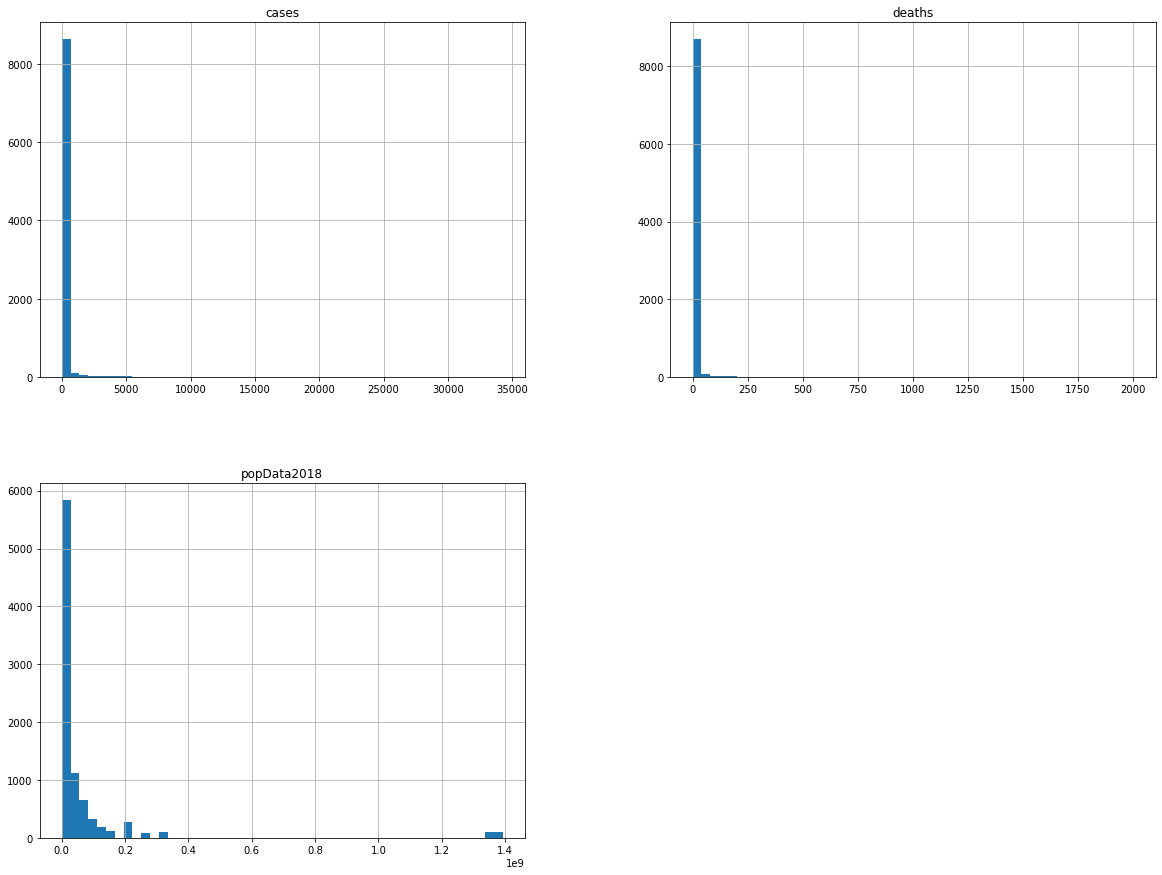

In [243]:
data.hist(bins=50, figsize=(20,15))
plt.savefig('temp__Histogram', format='svg')

## Looking for Correlations

In [141]:
corr_matrix = data.corr()
corr_matrix['deaths'].sort_values(ascending=False)

deaths         1.000000
cases          0.745339
popData2018    0.055614
Name: deaths, dtype: float64

## Calculate Case Growth Rate and Death Growth Rate

In [143]:
data['caseGrowthRate'] = 0
data['deathGrowthRate'] = 0
for row in data.iterrows():
    dateToday = row[1][0]
    cases = row[1][1]
    deaths = row[1][2]
    geoId = row[1][4]    
    dateTomorrow = dateToday + dt.timedelta(days=1)
    if len(data.loc[(data.date == dateTomorrow) & (data.geoId == geoId),].index) > 0: # is there data for tomorrow?
        # If so, retrieve tomorrow's death and case counts
        tomDeaths = int(data.loc[(data.date == dateTomorrow) & (data.geoId == geoId),'deaths'])
        tomCases = int(data.loc[(data.date == dateTomorrow) & (data.geoId == geoId),'cases'])
        # If applicable, calculate the case and death growth rates
        if deaths != 0 and tomDeaths != 0:
            data.loc[(data.date == dateTomorrow) & (data.geoId == geoId), 'deathGrowthRate'] = (tomDeaths / deaths) - 1
        if cases != 0 and tomCases != 0:
            data.loc[(data.date == dateTomorrow) & (data.geoId == geoId), 'caseGrowthRate'] = (tomCases / cases) - 1
    
data.head()    

,date,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,deathGrowthRate,caseGrowthRate
0,2020-04-05,35,1,Afghanistan,AF,AFG,37172386.0,0.0,0.000000
1,2020-04-04,0,0,Afghanistan,AF,AFG,37172386.0,0.0,0.000000
2,2020-04-03,43,0,Afghanistan,AF,AFG,37172386.0,0.0,0.653846
3,2020-04-02,26,0,Afghanistan,AF,AFG,37172386.0,0.0,0.040000
4,2020-04-01,25,0,Afghanistan,AF,AFG,37172386.0,0.0,-0.074074


## Experimenting with Attribute Combinations

In [144]:
data['deathsPerMillionPop'] = data['deaths'] / data['popData2018'] / 1000000
data['casesPerMillionPop'] = data['cases'] / data['popData2018'] / 1000000

In [145]:
data.head()

,date,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,deathGrowthRate,caseGrowthRate,deathsPerMillionPop,casesPerMillionPop
0,2020-04-05,35,1,Afghanistan,AF,AFG,37172386.0,0.0,0.000000,2.690169e-14,9.415591e-13
1,2020-04-04,0,0,Afghanistan,AF,AFG,37172386.0,0.0,0.000000,0.000000e+00,0.000000e+00
2,2020-04-03,43,0,Afghanistan,AF,AFG,37172386.0,0.0,0.653846,0.000000e+00,1.156773e-12
3,2020-04-02,26,0,Afghanistan,AF,AFG,37172386.0,0.0,0.040000,0.000000e+00,6.994439e-13
4,2020-04-01,25,0,Afghanistan,AF,AFG,37172386.0,0.0,-0.074074,0.000000e+00,6.725422e-13


## Time Series Analysis

In [146]:
filterCriteria = data['countryterritoryCode'] == 'USA'
usaData = data[filterCriteria]
usaData.head()

,date,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,deathGrowthRate,caseGrowthRate,deathsPerMillionPop,casesPerMillionPop
8604,2020-04-05,34272,1344,United_States_of_America,US,USA,327167434.0,0.217391,0.056962,4.107988e-12,1.047537e-10
8605,2020-04-04,32425,1104,United_States_of_America,US,USA,327167434.0,0.206557,0.125126,3.374419e-12,9.910827e-11
8606,2020-04-03,28819,915,United_States_of_America,US,USA,327167434.0,-0.135977,0.063314,2.796733e-12,8.808640e-11
8607,2020-04-02,27103,1059,United_States_of_America,US,USA,327167434.0,0.165017,0.084207,3.236875e-12,8.284137e-11
8608,2020-04-01,24998,909,United_States_of_America,US,USA,327167434.0,0.375189,0.157583,2.778394e-12,7.640736e-11


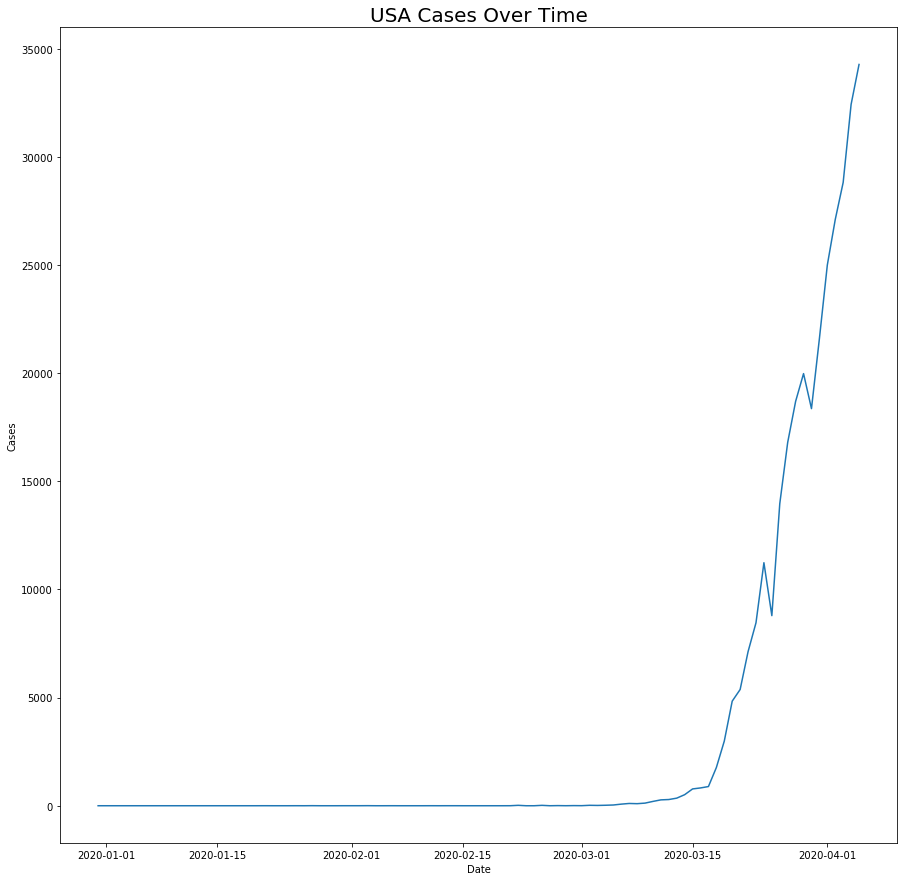

In [247]:
# Graph USA cases across time
plt.figure(figsize=(15,15))
plt.plot(usaData['date'], usaData['cases'])
plt.ylabel('Cases')
plt.xlabel('Date')
plt.title('USA Cases Over Time', fontdict = {'fontsize' : 20})
plt.show()

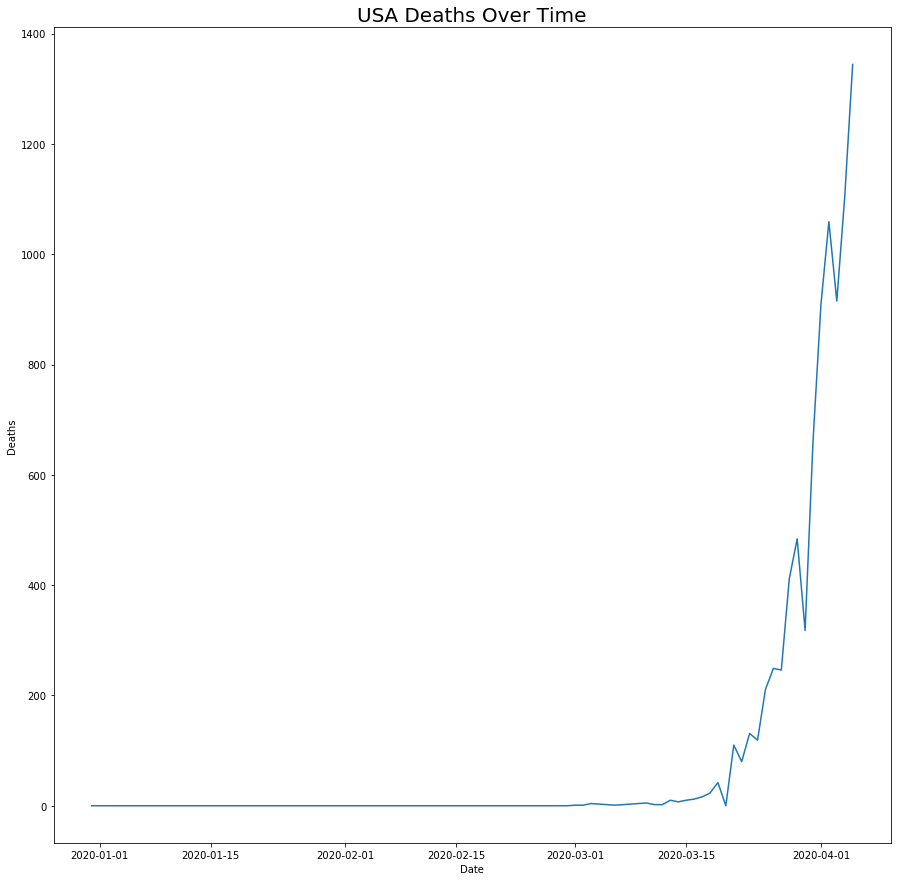

In [249]:
# Graph USA deaths across time
plt.figure(figsize=(15,15))
plt.plot(usaData['date'], usaData['deaths'])
plt.ylabel('Deaths')
plt.xlabel('Date')
plt.title('USA Deaths Over Time', fontdict = {'fontsize' : 20})
plt.show()

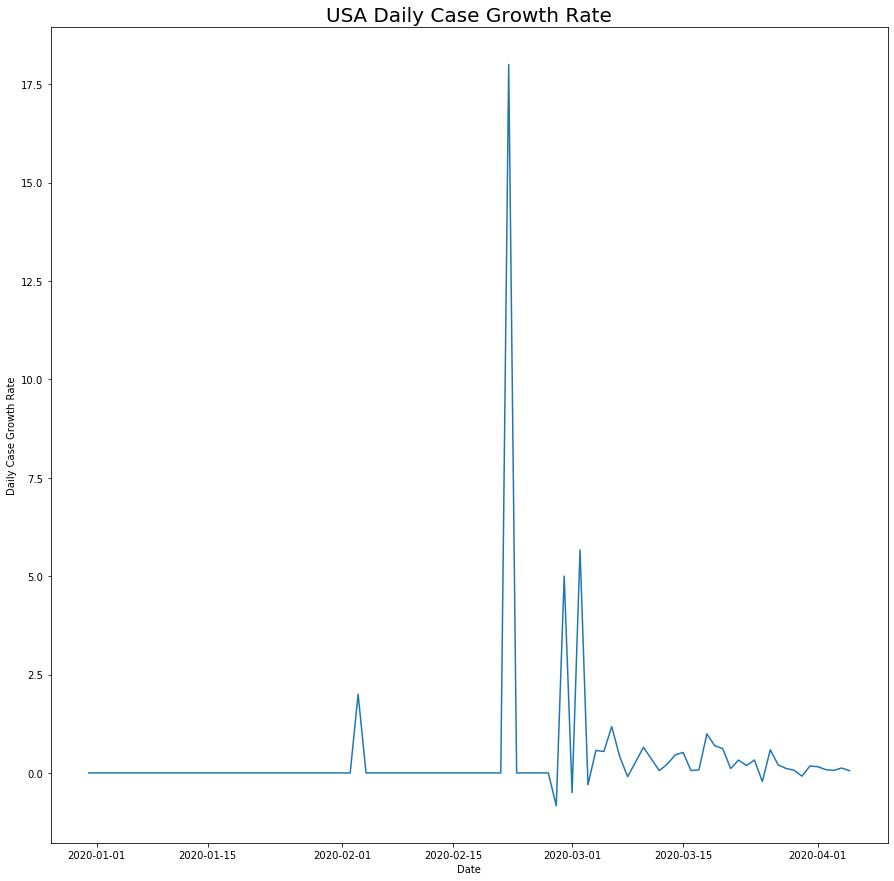

In [251]:
# Graph USA Case Growth Rate Across Time
plt.figure(figsize=(15,15))
plt.plot(usaData['date'], usaData['caseGrowthRate'])
plt.ylabel('Daily Case Growth Rate')
plt.xlabel('Date')
plt.title('USA Daily Case Growth Rate', fontdict = {'fontsize' : 20})
plt.show()

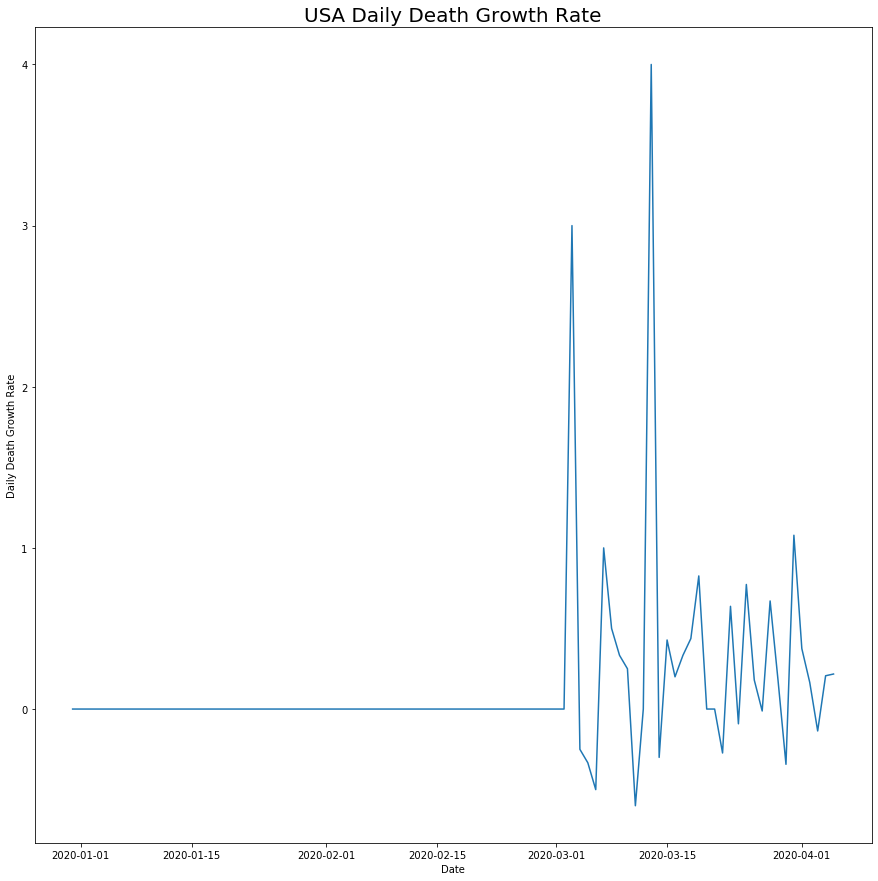

In [253]:
# Graph USA Case Growth Rate Across Time
plt.figure(figsize=(15,15))
plt.plot(usaData['date'], usaData['deathGrowthRate'])
plt.ylabel('Daily Death Growth Rate')
plt.xlabel('Date')
plt.title('USA Daily Death Growth Rate', fontdict = {'fontsize' : 20})
plt.show()

## Univariate Distributions

In [151]:
# Only look at data for 2020-04-01
filterCriteria = data['date'] == "2020-04-01"
aprilFirstData = data[filterCriteria]
aprilFirstData.head()

,date,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,deathGrowthRate,caseGrowthRate,deathsPerMillionPop,casesPerMillionPop
4,2020-04-01,25,0,Afghanistan,AF,AFG,37172386.0,0.0,-0.074074,0.000000e+00,6.725422e-13
91,2020-04-01,20,3,Albania,AL,ALB,2866376.0,0.5,0.818182,1.046618e-12,6.977452e-12
119,2020-04-01,6,4,Andorra,AD,AND,77006.0,1.0,-0.833333,5.194400e-11,7.791601e-11
135,2020-04-01,73,4,Algeria,DZ,DZA,42228429.0,1.0,0.280702,9.472292e-14,1.728693e-12
234,2020-04-01,0,0,Angola,AO,AGO,30809762.0,0.0,0.000000,0.000000e+00,0.000000e+00


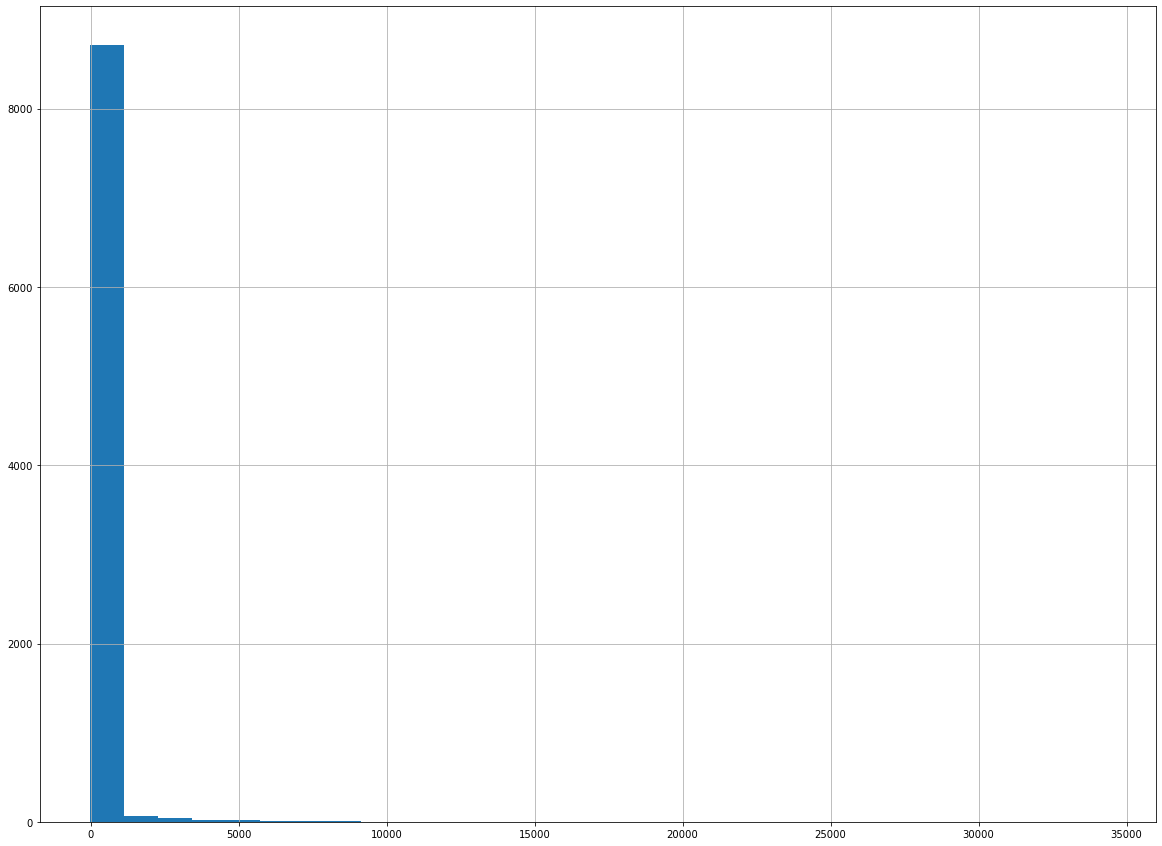

In [152]:
# Graph distribution of cases across countries
data['cases'].hist(bins=30, figsize=(20,15))

In [153]:
# Let's filter out countries with less than 100 cases
over100Cases = data.loc[(data.cases > 100) & (data.date == "2020-04-01")]
over100Cases = over100Cases.copy()
over100Cases.sort_values(by=['cases'], inplace=True, ascending=False)
over100Cases.head()

,date,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,deathGrowthRate,caseGrowthRate,deathsPerMillionPop,casesPerMillionPop
8608,2020-04-01,24998,909,United_States_of_America,US,USA,327167434.0,0.375189,0.157583,2.778394e-12,7.640736e-11
7619,2020-04-01,9222,849,Spain,ES,ESP,46723749.0,0.045567,0.441388,1.817063e-11,1.973729e-10
2919,2020-04-01,7578,499,France,FR,FRA,66987244.0,0.193780,0.731718,7.449179e-12,1.131260e-10
3170,2020-04-01,5453,149,Germany,DE,DEU,82927922.0,0.164062,0.181582,1.796741e-12,6.575590e-11
4317,2020-04-01,4053,839,Italy,IT,ITA,60431283.0,0.035802,0.000741,1.388354e-11,6.706791e-11


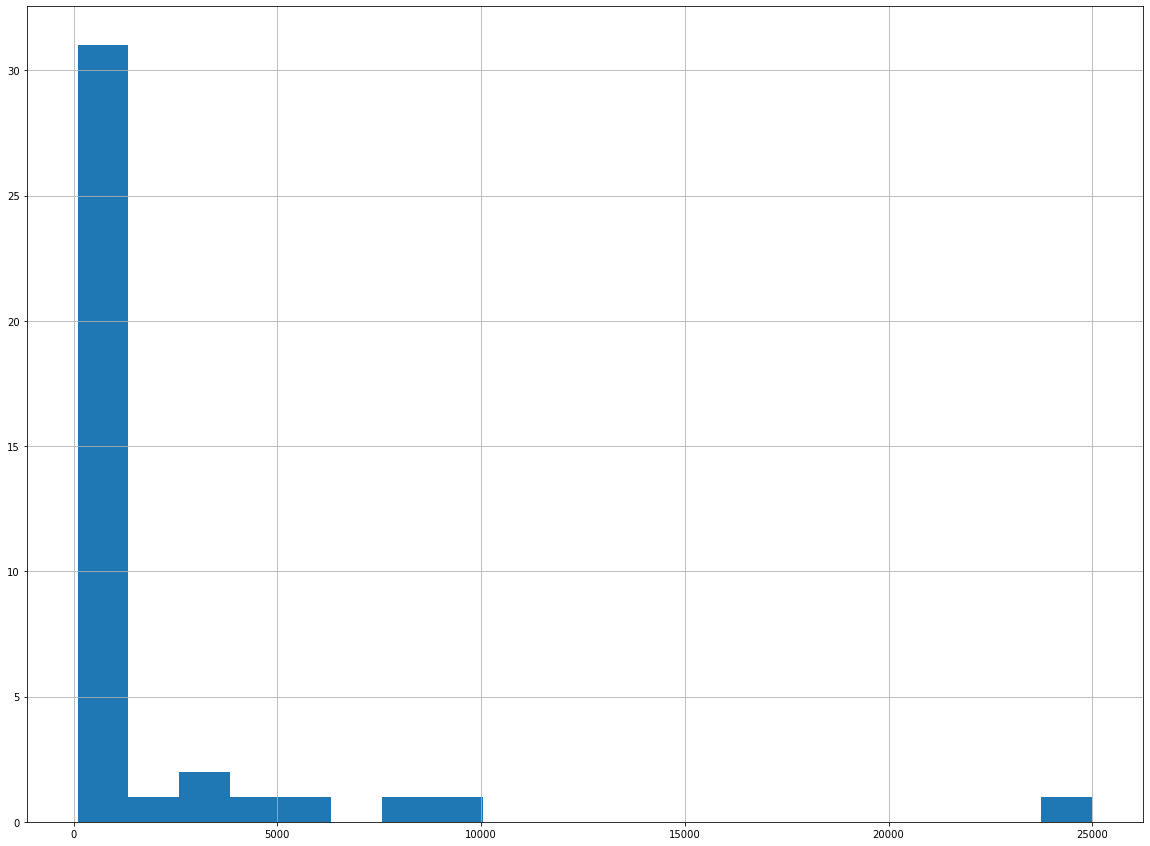

In [210]:
over100Cases['cases'].hist(bins = 20, figsize=(20,15))

## Bivariate Distribution

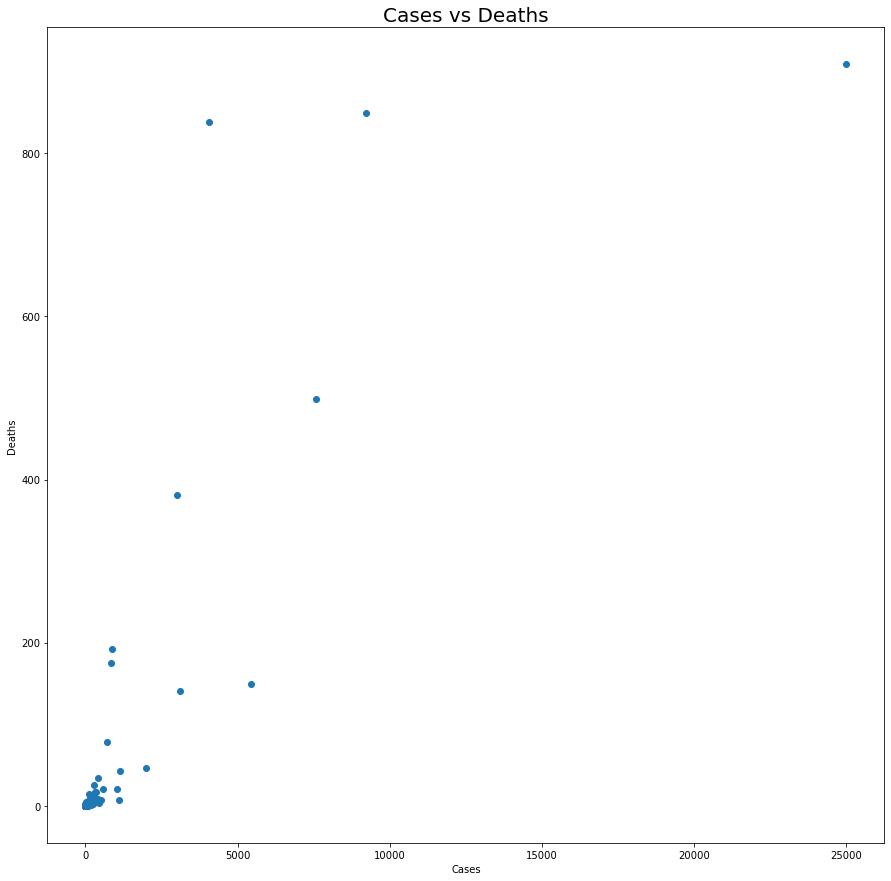

In [242]:
plt.figure(figsize=(15,15))
plt.scatter(aprilFirstData['cases'], aprilFirstData['deaths'])
plt.ylabel('Deaths')
plt.xlabel('Cases')
plt.title('Cases vs Deaths', fontdict = {'fontsize' : 20})
plt.show()

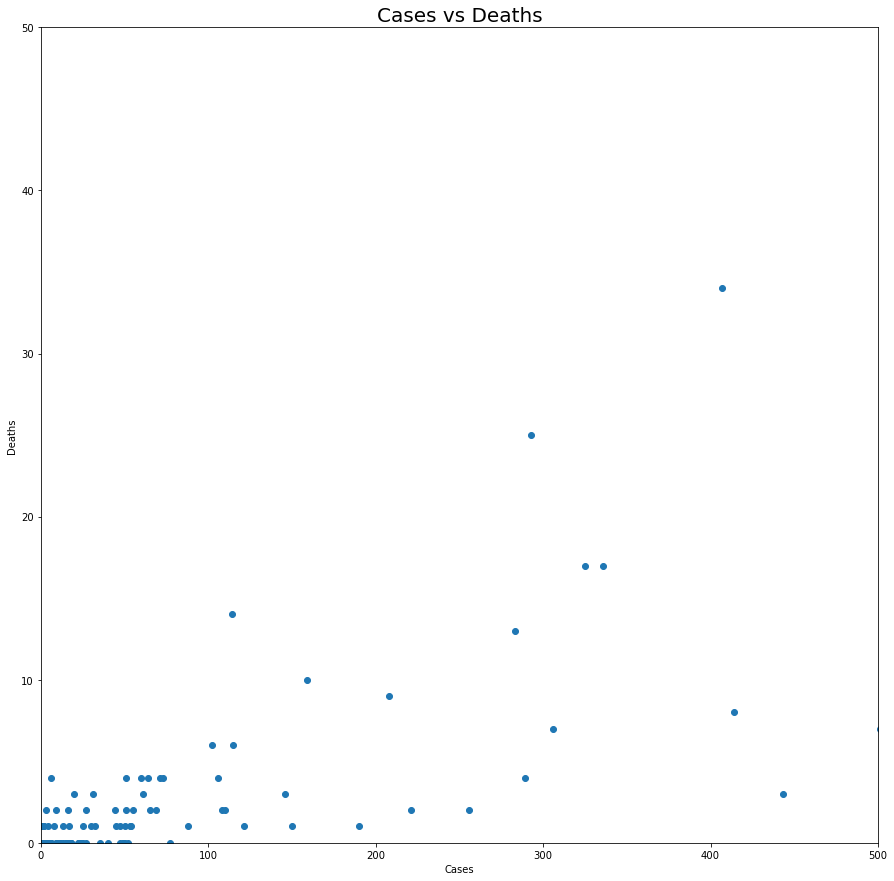

In [240]:
# Let's zoom in
plt.figure(figsize=(15,15))
plt.scatter(aprilFirstData['cases'], aprilFirstData['deaths'])
plt.xlim(0, 500)
plt.ylim(0, 50)
plt.ylabel('Deaths')
plt.xlabel('Cases')
plt.title('Cases vs Deaths', fontdict = {'fontsize' : 20})
plt.show()


## Scalers

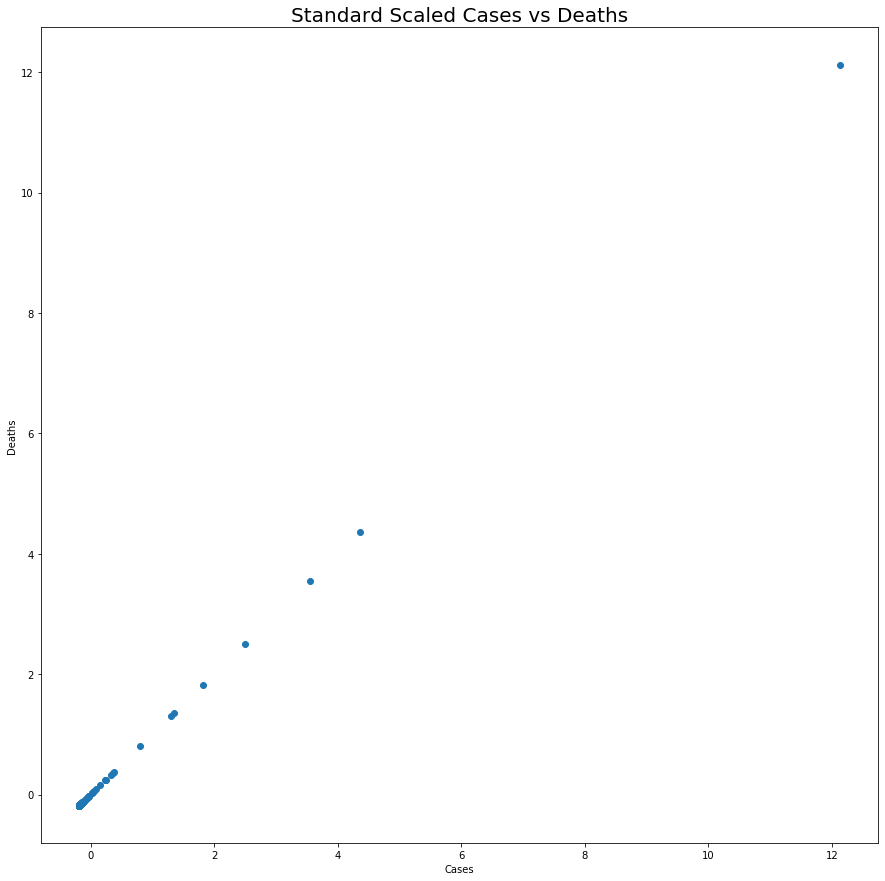

In [239]:
# Scale cases and deaths with standard scaler
standardScaler = StandardScaler()
standardScaler.fit(aprilFirstData[['cases', 'deaths']])
standardScaledData = standardScaler.transform(aprilFirstData[['cases', 'deaths']])
plt.figure(figsize=(15,15))
plt.scatter(standardScaledData[:,0], standardScaledData[:,0])
plt.ylabel('Deaths')
plt.xlabel('Cases')
plt.title('Standard Scaled Cases vs Deaths', fontdict = {'fontsize' : 20})
plt.show()

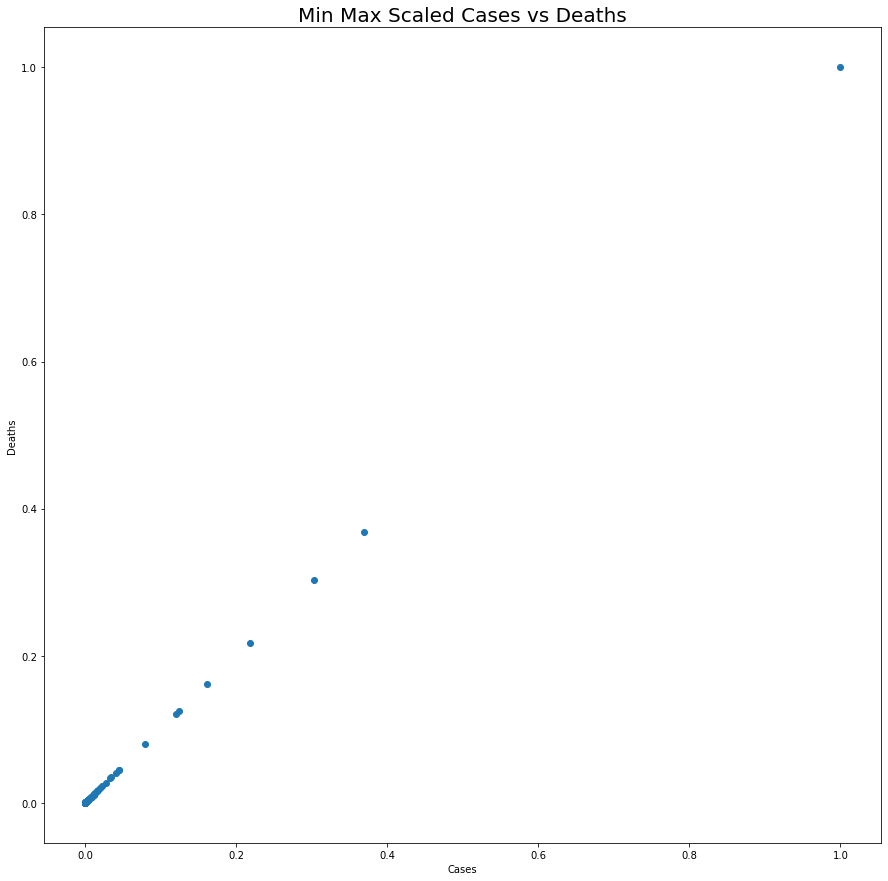

In [238]:
# Scale cases and deaths with min max scaler
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(aprilFirstData[['cases', 'deaths']])
minMaxScaledData = minMaxScaler.transform(aprilFirstData[['cases', 'deaths']])
plt.figure(figsize=(15,15))
plt.scatter(minMaxScaledData[:,0], minMaxScaledData[:,0])
plt.ylabel('Deaths')
plt.xlabel('Cases')
plt.title('Min Max Scaled Cases vs Deaths', fontdict = {'fontsize' : 20})
plt.show()

In [265]:
!jupyter nbconvert --to html "Exploratory Data Analysis.ipynb"

[NbConvertApp] Converting notebook Exploratory Data Analysis.ipynb to html
[NbConvertApp] Writing 636250 bytes to Exploratory Data Analysis.html
